# **Step 1: Import the Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# Credit Card Fraud Detection Dataset (2023) - Feature Description

## Dataset Overview
- **Year:** 2023  
- **Records:** ~560,000 credit card transactions by European cardholders  
- **Goal:** Develop fraud detection models to classify transactions as **fraudulent (1)** or **legitimate (0)**  
- **Privacy:** Sensitive details are anonymized → raw features transformed into **V1–V28** components  

---

## Features Explained

### 1. `id`
- Unique identifier for each transaction  
- Mostly used for indexing and tracking, **not predictive**  
- Usually dropped during model training  

---

### 2. `V1 – V28`
- **Anonymized numerical features** created using PCA (Principal Component Analysis) or similar transformations  
- Original features (merchant ID, location, device, demographics, etc.) were anonymized for privacy  
- Capture transaction behavior and hidden patterns:
  - Spending habits  
  - Timing of purchases  
  - Merchant-related attributes  
  - Correlations between transaction details  
- **Most important features** for fraud detection, though exact meanings are undisclosed  

---

### 3. `Amount`
- Transaction amount (in euros)  
- Fraud patterns may appear in:
  - **High-value frauds** → maximize attacker’s gain  
  - **Small repeated frauds** → test the card before larger charges  
- Often normalized or scaled (e.g., log transform or standardization) before modeling  

---

### 4. `Class`
- **Target variable (label)** for fraud detection  
- Binary classification:
  - `0` → Legitimate transaction  
  - `1` → Fraudulent transaction  
- Dataset is **highly imbalanced** (frauds are <1% of all transactions)  
- Imbalance handling techniques: SMOTE, undersampling, anomaly detection, or cost-sensitive learning  


# **Step 2: Load Data / Explore Data**

In [2]:
data = pd.read_csv('creditcard_2023.csv')
pd.set_option('display.max_columns', None)
data.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,-0.987020,0.293438,-0.941386,0.549020,1.804879,0.215598,0.512307,0.333644,0.124270,0.091202,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,0.140107,1.564246,0.574074,0.627719,0.706121,0.789188,0.403810,0.201799,-0.340687,-0.233984,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,-0.272985,0.659201,0.805173,0.616874,3.069025,-0.577514,0.886526,0.239442,-2.366079,0.361652,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,-0.752581,0.737483,0.592994,0.559535,-0.697664,-0.030669,0.242629,2.178616,-1.345060,-0.378223,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,-1.203171,1.029577,1.439310,0.241454,0.153008,0.224538,0.366466,0.291782,0.445317,0.247237,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [3]:
data.tail()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
568625,568625,-0.833437,0.061886,-0.899794,0.904227,-1.002401,0.481454,-0.370393,0.189694,-0.938153,-1.161847,1.430971,-1.330500,-1.580730,-1.363454,0.287766,-1.480796,-1.520928,-1.376970,1.789103,-0.751011,0.167503,0.419731,1.288249,-0.900861,0.560661,-0.006018,3.308968,0.081564,4394.16,1
568626,568626,-0.670459,-0.202896,-0.068129,-0.267328,-0.133660,0.237148,-0.016935,-0.147733,0.483894,-0.210817,0.173590,-0.539948,0.738315,-0.812043,0.870447,-0.545184,-0.575991,-0.664313,0.101604,-0.550260,0.031874,0.388161,-0.154257,-0.846452,-0.153443,1.961398,-1.528642,1.704306,4653.40,1
568627,568627,-0.311997,-0.004095,0.137526,-0.035893,-0.042291,0.121098,-0.070958,-0.019997,-0.122048,-0.144495,0.477582,-0.461849,-0.606100,-0.395126,-0.040673,-0.370201,-0.729002,-0.251679,-0.343196,-0.076417,0.140788,0.536523,-0.211100,-0.448909,0.540073,-0.755836,-0.487540,-0.268741,23572.85,1
568628,568628,0.636871,-0.516970,-0.300889,-0.144480,0.131042,-0.294148,0.580568,-0.207723,0.893527,-0.080078,-0.324934,0.335215,0.464177,-0.390369,0.893881,0.477402,0.848443,0.930280,-0.481058,0.288186,-0.060381,-0.195609,-0.175488,-0.554643,-0.099669,-1.434931,-0.159269,-0.076251,10160.83,1
568629,568629,-0.795144,0.433236,-0.649140,0.374732,-0.244976,-0.603493,-0.347613,-0.340814,0.253971,-0.513556,0.892136,-1.153011,0.489197,-1.062488,0.207773,-0.917240,-0.936114,-0.823688,-0.330408,-0.621378,0.534853,-0.291514,0.157303,0.931030,-0.349423,-1.090974,-1.575113,0.722936,21493.92,1


In [4]:
print(f"Number of Rows in dataset: {data.shape[0]}\nNumber of Columns in dataset: {data.shape[1]}")

Number of Rows in dataset: 568630
Number of Columns in dataset: 31


# **Step 3: Check the Class Imbalance**

In [5]:
Class = data['Class'].value_counts(normalize = True) * 100
Class

Class
0    50.0
1    50.0
Name: proportion, dtype: float64

### **Inshight:**
- Class is balanced
- 50% are Normal Transaction
- 50% are Fraud Transaction

# **Step 4: Data Cleaning / Exploratory Data Analysis**

In [6]:
# remove the id column(It is not reqired for prediction)
data.drop('id', axis = 1, inplace = True)

In [7]:
data.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      568630 non-null  float64
 1   V2      568630 non-null  float64
 2   V3      568630 non-null  float64
 3   V4      568630 non-null  float64
 4   V5      568630 non-null  float64
 5   V6      568630 non-null  float64
 6   V7      568630 non-null  float64
 7   V8      568630 non-null  float64
 8   V9      568630 non-null  float64
 9   V10     568630 non-null  float64
 10  V11     568630 non-null  float64
 11  V12     568630 non-null  float64
 12  V13     568630 non-null  float64
 13  V14     568630 non-null  float64
 14  V15     568630 non-null  float64
 15  V16     568630 non-null  float64
 16  V17     568630 non-null  float64
 17  V18     568630 non-null  float64
 18  V19     568630 non-null  float64
 19  V20     568630 non-null  float64
 20  V21     568630 non-null  float64
 21  V22     56

In [9]:
# Descriptive Statistics
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000,568630.0
mean,-5.638058e-17,-1.319545e-16,-3.518788e-17,-2.879008e-17,7.997245e-18,-3.958636e-17,-3.198898e-17,2.109273e-17,3.998623e-17,1.991314e-16,-1.183592e-16,-5.758017e-17,-5.698037e-18,-4.078595e-17,2.649087e-17,-1.719408e-17,-3.398829e-17,-5.837989e-17,2.479146e-17,-1.579456e-17,4.758361e-17,3.948640e-18,6.194741e-18,-2.799036e-18,-3.178905e-17,-7.497417e-18,-3.598760e-17,2.609101e-17,12041.957635,0.5
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,6919.644449,0.5
min,-3.495584e+00,-4.996657e+01,-3.183760e+00,-4.951222e+00,-9.952786e+00,-2.111111e+01,-4.351839e+00,-1.075634e+01,-3.751919e+00,-3.163276e+00,-5.954723e+00,-2.020399e+00,-5.955227e+00,-2.107417e+00,-3.861813e+00,-2.214513e+00,-2.484938e+00,-2.421949e+00,-7.804988e+00,-7.814784e+01,-1.938252e+01,-7.734798e+00,-3.029545e+01,-4.067968e+00,-1.361263e+01,-8.226969e+00,-1.049863e+01,-3.903524e+01,50.010000,0.0
25%,-5.652859e-01,-4.866777e-01,-6.492987e-01,-6.560203e-01,-2.934955e-01,-4.458712e-01,-2.835329e-01,-1.922572e-01,-5.687446e-01,-5.901008e-01,-7.014495e-01,-8.311331e-01,-6.966667e-01,-8.732057e-01,-6.212485e-01,-7.162655e-01,-6.194913e-01,-5.560458e-01,-5.653082e-01,-3.502399e-01,-1.664408e-01,-4.904892e-01,-2.376289e-01,-6.515801e-01,-5.541485e-01,-6.318948e-01,-3.049607e-01,-2.318783e-01,6054.892500,0.0
50%,-9.363846e-02,-1.358939e-01,3.528579e-04,-7.376152e-02,8.108788e-02,7.871758e-02,2.333659e-01,-1.145242e-01,9.252647e-02,2.626145e-01,-4.104986e-02,1.620521e-01,1.760812e-02,2.305011e-01,-3.925566e-02,1.340262e-01,2.716407e-01,8.729382e-02,-2.597869e-02,-1.233776e-01,-3.743065e-02,-2.732881e-02,-5.968903e-02,1.590123e-02,-8.193162e-03,-1.189208e-02,-1.729111e-01,-1.392973e-02,12030.150000,0.5
75%,8.326582e-01,3.435552e-01,6.285380e-01,7.070047e-01,4.397368e-01,4.977881e-01,5.259548e-01,4.729905e-02,5.592621e-01,5.924603e-01,7.477730e-01,7.446723e-01,6.856048e-01,7.518216e-01,6.654065e-01,6.556061e-01,5.182242e-01,5.443887e-01,5.601164e-01,2.482164e-01,1.479787e-01,4.638817e-01,1.557153e-01,7.007374e-01,5.500147e-01,6.728879e-01,3.340230e-01,4.095903e-01,18036.330000,1.0
max,2.229046e+00,4.361865e+00,1.412583e+01,3.201536e+00,4.271689e+01,2.616840e+01,2.178730e+02,5.958040e+00,2.027006e+01,3.172271e+01,2.513573e+00,1.791356e+01,7.187486e+00,1.916954e+01,1.453220e+01,4.665291e+01,6.994124e+00,6.783716e+00,3.831672e+00,2.987281e+01,8.087080e+00,1.263251e+01,3.170763e+01,1.296564e+01,1.462151e+01,5.623285e+00,1.132311e+02,7.725594e+01,24039.930000,1.0


In [10]:
data.isna().sum() # There is no missing values so no need to imputing the missing values

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [11]:
# Check the Duplicates
data.duplicated().sum()

1

In [12]:
# Duplicated row is available
data[data.duplicated()]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
510531,-1.704517,2.599199,-1.205391,0.503527,-0.949674,3.226002,-2.323095,-6.027712,0.273389,-0.698893,0.990274,-0.70778,-1.891977,-1.183117,-0.287687,-1.230971,-0.722383,-0.99063,-0.169996,-4.118596,8.08708,-6.450353,6.343132,-1.075048,0.349881,-0.240261,1.534445,2.154102,22549.29,1


In [13]:
# Drop the duplicate values
data.drop_duplicates(inplace = True)

In [14]:
data.duplicated().sum()

0

In [15]:
# Check the Unique values of Class variable
data['Class'].unique()

array([0, 1], dtype=int64)

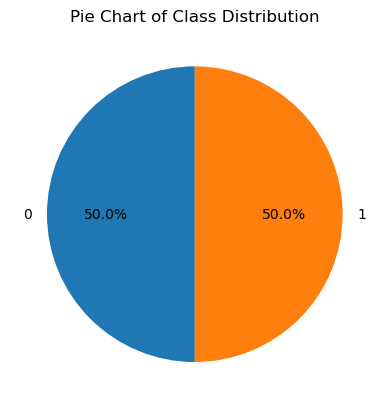

In [16]:
plt.pie(Class, labels=Class.index, autopct="%.1f%%", startangle=90)
plt.title("Pie Chart of Class Distribution")
plt.show()

# **Step 5: Train/Test Split**

In [17]:
X = data.drop('Class', axis = 1)
y = data['Class']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.3, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((398040, 29), (170589, 29), (398040,), (170589,))

# **Step 6: Feature Scaling**

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Step 7: Trian the Model**

## **Model 1: Logistic Regression**

In [20]:
logr_model = LogisticRegression(random_state = 42)
logr_model

LogisticRegression(random_state=42)

In [21]:
logr_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [22]:
y_logr_pred = logr_model.predict(X_test_scaled)
y_logr_pred

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

## **Model 2: RandomForestClassifier**

In [23]:
rfc = RandomForestClassifier(class_weight = 'balanced', n_estimators = 100, random_state=42)
rfc

RandomForestClassifier(class_weight='balanced', random_state=42)

In [24]:
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [25]:
y_rfc_pred = rfc.predict(X_test_scaled)
y_rfc_pred

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

## **Model 3: XGBClassifier**

In [26]:
N_pos = sum(y == 1)   # fraud
N_neg = sum(y == 0)   # legit
scale_weight = N_neg / N_pos
print("Scale weight:", scale_weight)

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_weight,
    gamma=0,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

xgb_model.fit(X_train_scaled, y_train)

Scale weight: 1.0000035172379833


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, ...)

In [27]:
y_xgb_pred = xgb_model.predict(X_test_scaled)
y_xgb_pred

array([1, 1, 0, ..., 1, 1, 1])

## **Model 3: LGBMClassifier**

In [28]:
N_pos = sum(y == 1)   # fraud
N_neg = sum(y == 0)   # legit
scale_weight = N_neg / N_pos
print("Scale weight:", scale_weight)

lgbm_model = LGBMClassifier(
    n_estimators=500,
    max_depth = -1,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    num_leaves=64,
    scale_pos_weight=scale_weight,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1)

lgbm_model.fit(X_train_scaled, y_train)

Scale weight: 1.0000035172379833
[LightGBM] [Info] Number of positive: 198889, number of negative: 199151
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499671 -> initscore=-0.001316
[LightGBM] [Info] Start training from score -0.001316


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=500,
               n_jobs=-1, num_leaves=64, random_state=42, reg_lambda=1,
               scale_pos_weight=1.0000035172379833, subsample=0.8)

In [29]:
y_lgbm_pred = lgbm_model.predict(X_test_scaled)
y_lgbm_pred

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

# **Step 8: Model Evaluation**

In [30]:
print("Logistic Regression:\n")
print(f"Accutracy Score : {accuracy_score(y_test, y_logr_pred)}")
print()
print(f"Confusion Matrix :\n{confusion_matrix(y_test, y_logr_pred)}")
print()
print(f"Classification Report :\n{classification_report(y_test, y_logr_pred)}")
print()
print(f"roc_auc_score : {roc_auc_score(y_test, y_logr_pred)}")

Logistic Regression:

Accutracy Score : 0.9649977431135653

Confusion Matrix :
[[83304  1860]
 [ 4111 81314]]

Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     85164
           1       0.98      0.95      0.96     85425

    accuracy                           0.96    170589
   macro avg       0.97      0.97      0.96    170589
weighted avg       0.97      0.96      0.96    170589


roc_auc_score : 0.9650178501849596


In [31]:
print("Random Forest Classifier:\n")
print(f"Accutracy Score : {accuracy_score(y_test, y_rfc_pred)}")
print()
print(f"Confusion Matrix :\n{confusion_matrix(y_test, y_rfc_pred)}")
print()
print(f"Classification Report :\n{classification_report(y_test, y_rfc_pred)}")
print()
print(f"roc_auc_score : {roc_auc_score(y_test, y_rfc_pred)}")

Random Forest Classifier:

Accutracy Score : 0.9998768971035648

Confusion Matrix :
[[85143    21]
 [    0 85425]]

Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85164
           1       1.00      1.00      1.00     85425

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589


roc_auc_score : 0.9998767084683668


In [32]:
print("XGBoost Classifier:\n")
print(f"Accutracy Score : {accuracy_score(y_test, y_xgb_pred)}")
print()
print(f"Confusion Matrix :\n{confusion_matrix(y_test, y_xgb_pred)}")
print()
print(f"Classification Report :\n{classification_report(y_test, y_xgb_pred)}")
print()
print(f"roc_auc_score : {roc_auc_score(y_test, y_xgb_pred)}")

XGBoost Classifier:

Accutracy Score : 0.9998534489328151

Confusion Matrix :
[[85139    25]
 [    0 85425]]

Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85164
           1       1.00      1.00      1.00     85425

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589


roc_auc_score : 0.9998532243671034


In [33]:
print("LightGBM Classifier:\n")
print(f"Accutracy Score : {accuracy_score(y_test, y_lgbm_pred)}")
print()
print(f"Confusion Matrix :\n{confusion_matrix(y_test, y_lgbm_pred)}")
print()
print(f"Classification Report :\n{classification_report(y_test, y_lgbm_pred)}")
print()
print(f"roc_auc_score : {roc_auc_score(y_test, y_lgbm_pred)}")

LightGBM Classifier:

Accutracy Score : 0.9998651730181899

Confusion Matrix :
[[85141    23]
 [    0 85425]]

Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85164
           1       1.00      1.00      1.00     85425

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589


roc_auc_score : 0.9998649664177353


# **Step 9: Feature Importances**

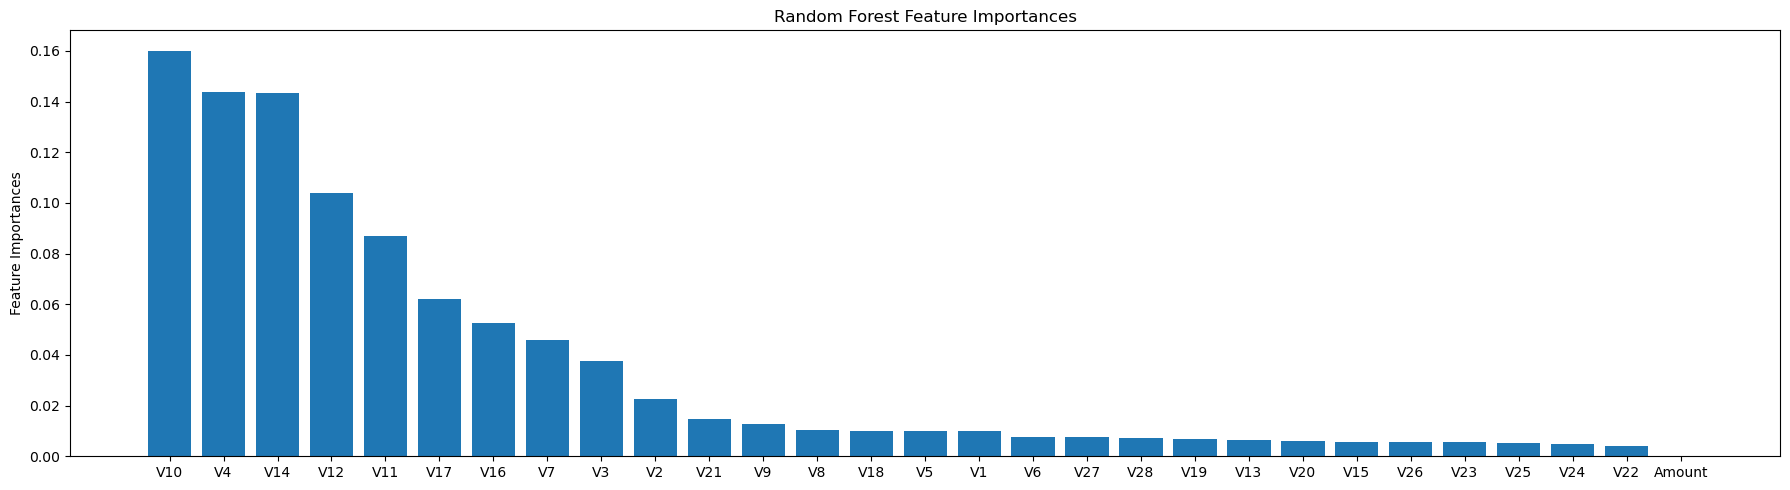

In [34]:
importances = rfc.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'importance' : importances,
    'feature' : feature_names
})

feature_importance_df = feature_importance_df.sort_values(by = 'importance', ascending = False)


# plot
plt.figure(figsize = (18, 5))
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.title("Random Forest Feature Importances")
plt.ylabel("Feature Importances")
plt.tight_layout()
plt.show()

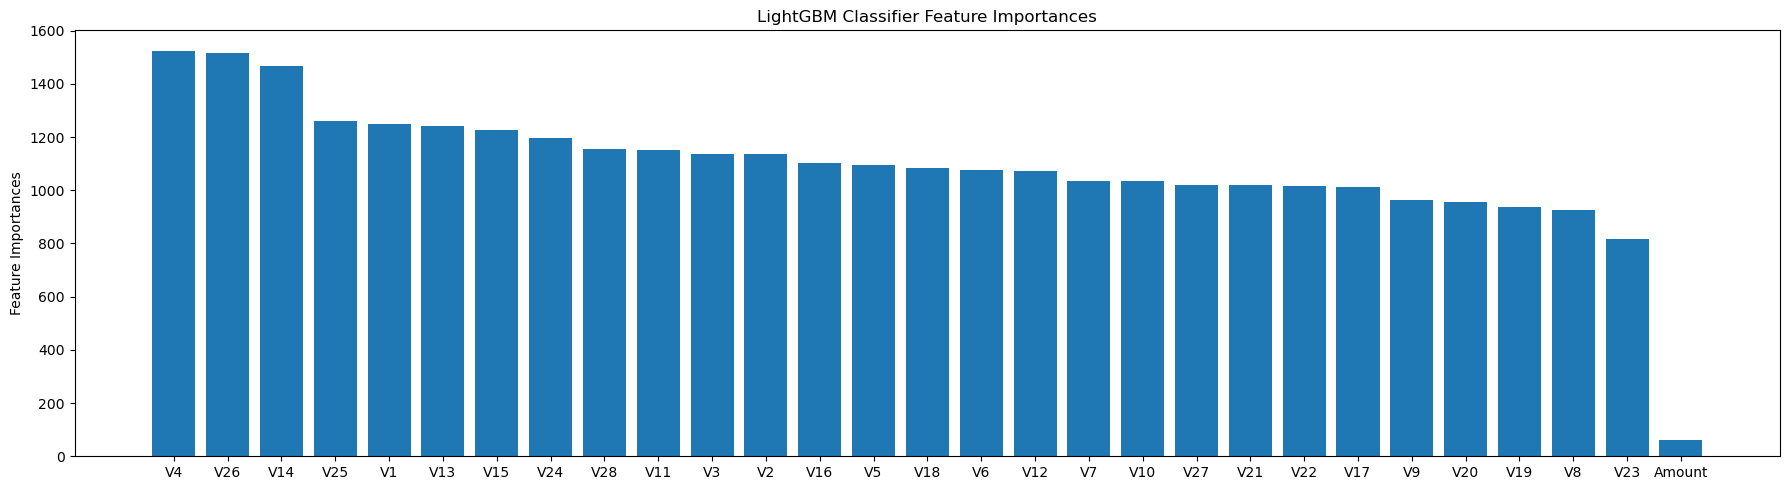

In [35]:
importances = lgbm_model.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'importance' : importances,
    'feature' : feature_names
})

feature_importance_df = feature_importance_df.sort_values(by = 'importance', ascending = False)


# plot
plt.figure(figsize = (18, 5))
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.title("LightGBM Classifier Feature Importances")
plt.ylabel("Feature Importances")
plt.tight_layout()
plt.show()

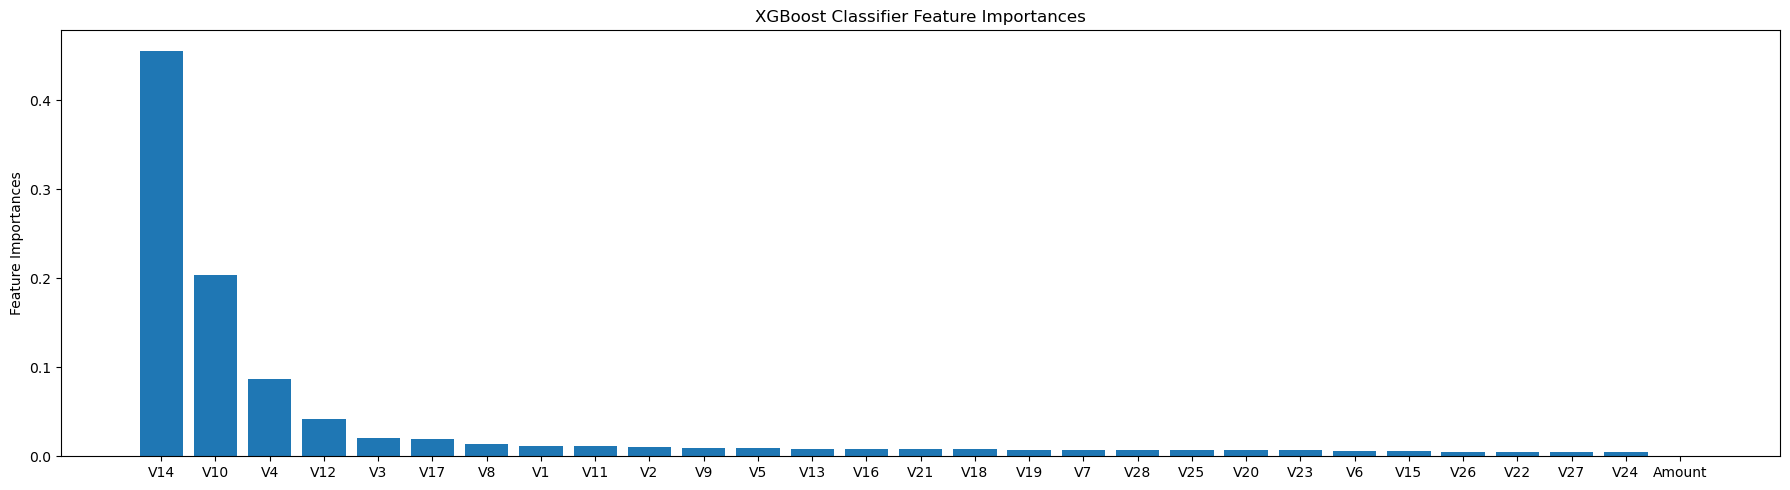

In [36]:
importances = xgb_model.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'importance' : importances,
    'feature' : feature_names
})

feature_importance_df = feature_importance_df.sort_values(by = 'importance', ascending = False)


# plot
plt.figure(figsize = (18, 5))
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.title("XGBoost Classifier Feature Importances")
plt.ylabel("Feature Importances")
plt.tight_layout()
plt.show()

# **Save the model in pickle**

In [154]:
import pickle

scalers = {}

for col in X.columns:
    scaler = StandardScaler()
    data[[col]] = scaler.fit_transform(data[[col]])
    
    scalers[col] = scaler

models = {'RandomForest Classifier': rfc, 'LightGBM Classifier': lgbm_model}

# save the scalers to a pickle file
with open('scalers.pkl', 'wb') as file:
    pickle.dump(scalers, file)


# Save models
with open("models.pkl", "wb") as file:
    pickle.dump(models, file)    


# **Load the saved model and scalers**

In [43]:
import pickle
with open('scalers.pkl', 'rb') as file:
    scalers = pickle.load(file)

with open("models.pkl", "rb") as file:
    models = pickle.load(file)  


In [45]:
input_data = {
    "V1": -2.420791,
    "V2": 2.934369,
    "V3": -2.331007,
    "V4": 1.250057,
    "V5": -2.945707,
    "V6": -2.678884,
    "V7": -2.261141,
    "V8": 4.896335,
    "V9": -1.114550,
    "V10": -1.239189,
    "V11": 1.069445,
    "V12": -0.995042,
    "V13": 0.977878,
    "V14": -0.844612,
    "V15": -0.117386,
    "V16": -1.178868,
    "V17": -1.390364,
    "V18": -1.435328,
    "V19": 0.499559,
    "V20": 1.439752,
    "V21": 0.563694,
    "V22": -1.618982,
    "V23": -1.177546,
    "V24": 0.348140,
    "V25": 3.067770,
    "V26": -0.510204,
    "V27": 1.746623,
    "V28": 0.888682,
    "Amount": 13030.78
}


input_data_df = pd.DataFrame([input_data])

# scaling variables using saved scalers file
for col, scaler in scalers.items():
    input_data_df[[col]] = scaler.transform(input_data_df[[col]])

# select the model
model_1 = models['RandomForest Classifier']
model_2 = models['LightGBM Classifier']

prediction = model_2.predict(input_data_df)
pred_prob = model_2.predict_proba(input_data_df)

print('Prediction Result')
print(f"Predicted Class is : {prediction[0]}")
print()

print('Prediction Probabilities:')
for i, prob in enumerate(pred_prob.flatten()):
    print(f"Class {i}: {prob * 100:.1f}%")

Prediction Result
Predicted Class is : 1

Prediction Probabilities:
Class 0: 0.0%
Class 1: 100.0%


In [46]:
from sklearn.tree import DecisionTreeClassifier

In [72]:
dt = DecisionTreeClassifier(
    criterion="gini",         
    max_depth=6,              
    min_samples_split=10,    
    min_samples_leaf=5,       
    class_weight="balanced",
    random_state=42
)

dt

DecisionTreeClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=5,
                       min_samples_split=10, random_state=42)

In [73]:
dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=5,
                       min_samples_split=10, random_state=42)

In [74]:
y_pred = dt.predict(X_test_scaled)
y_pred

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [75]:
print("DecisionTree Classifier:\n")
print(f"Accutracy Score : {accuracy_score(y_test, y_pred)}")
print()
print(f"Confusion Matrix :\n{confusion_matrix(y_test, y_pred)}")
print()
print(f"Classification Report :\n{classification_report(y_test, y_pred)}")
print()
print(f"roc_auc_score : {roc_auc_score(y_test, y_pred)}")

DecisionTree Classifier:

Accutracy Score : 0.9656073955530544

Confusion Matrix :
[[82919  2245]
 [ 3622 81803]]

Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     85164
           1       0.97      0.96      0.97     85425

    accuracy                           0.97    170589
   macro avg       0.97      0.97      0.97    170589
weighted avg       0.97      0.97      0.97    170589


roc_auc_score : 0.9656196652276418
